# Lane Detection

In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def birdseye_transform(camera_image, inverse=False):
    OUT_H_FACTOR = 8
    IMAGE_H = 223
    IMAGE_W = 1280

    src = np.float32([[0, 625], [1280, 625], [0, 0], [1280, 0]])
    dst = np.float32([[620, 625], [1280-620, 625], [0, 0], [1280, 0]])

    M = cv2.getPerspectiveTransform(src, dst) # The transformation matrix
    Minv = cv2.getPerspectiveTransform(dst, src) # Inverse transformation

    img = camera_image[445:, :] # Apply np slicing for ROI crop
    warped_img = cv2.warpPerspective(img, M if not inverse else Minv, (1280, 625)) # Image warping
    return warped_img

def preprocess_image(img):
    # Extract white and yellow line marker
    lower_yellow = np.array([20, 100, 100], dtype=np.uint8)
    upper_yellow = np.array([30, 255, 255], dtype=np.uint8)

    hsv_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    mask_yellow = cv2.inRange(hsv_image, lower_yellow, upper_yellow)
    mask_white = cv2.inRange(gray_image, 150, 255)
    mask_yw = cv2.bitwise_or(mask_white, mask_white)

    mask_yw_image = cv2.bitwise_and(gray_image, mask_yw)

    # Canny edge detection
    kernel_size = 5
    gauss_gray = cv2.GaussianBlur(mask_yw_image, (kernel_size, kernel_size), 0)

    low_threshold = 50
    high_threshold = 150
    canny_edges = cv2.Canny(gauss_gray, low_threshold, high_threshold)

    return canny_edges

def get_slope(x1,y1,x2,y2):
    return (y2-y1)/(x2-x1)

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def interpolate_hough(img, lines):
    height, width = img.shape
    interploated_lines = []
    for line in lines:
        for x1, y1, x2, y2 in line:
            # straight line
            if x1 == x2:
                interploated_lines.append([(x1, 0, x2, height)])
                continue
            
            # not straight line
            # if the line is too horizontal, skip
            slope = get_slope(x1,y1,x2,y2)
            if np.rad2deg(np.arctan(abs(slope))) < 80 or np.rad2deg(np.arctan(abs(slope))) > 110:
                continue
            
            m_inv = (x2-x1)/(y2-y1)
            interpolated_x1 = m_inv * (0 - y1) + x1
            interpolated_x2 = m_inv * (height - y1) + x1
            interploated_lines.append([(interpolated_x1, 0, interpolated_x2, height)])
    return np.asarray(interploated_lines, dtype=np.int32)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    lines_interpolated = interpolate_hough(img, lines)
    lines_interpolated = filter_merge_hough(img, lines_interpolated)
    # return lines
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    # draw_lines(line_img, lines)
    draw_lines_raw(line_img, lines_interpolated)
    return line_img

def filter_merge_hough(img, lines, lane_width=15):
    filtered = []
    for line in lines:
        for x1, y1, x2, y2 in line:
            matched = False
            for l in range(len(filtered)):
                closest = 10000000
                for x1f, y1f, x2f, y2f in filtered[l]:
                    if x1f == np.inf:
                        if abs(x2-x2f) < lane_width and abs(x2-x2f) < closest:
                            filtered[l] = [(x1, y1, (x2 + x2f)/2, y2)]
                            matched = True
                            closest = abs(x2-x2f)
                    elif abs(x1-x1f) < lane_width or abs(x2-x2f) < lane_width:
                        filtered[l] = [((x1 + x1f)/2, y1, (x2 + x2f)/2, y2)]
                        matched = True
            if matched == False:
                filtered.append([(x1, y1, x2, y2)])
    
    return np.asarray(filtered, dtype=np.int32)

# Return [[x11, x12, ..., xmn], ..., [xi1, ..., xmn]]
def multi_segment_hough(img, rho, theta, threshold, min_line_len, max_line_gap, segment_count=4, lane_width=15):
    segment_width, segment_height = img.shape[1]//segment_count, img.shape[0]//segment_count
    all_segment_lines = []
    for i in range(segment_count-1, 0, -1):
        img_s = img[i*segment_height:(i+1)*segment_height]
        prev_lines = [] if i == segment_count-1 else all_segment_lines[0].tolist()   # prev lines always in first place
        for line in prev_lines:
            for l in line:
                l[2] = l[0]
                l[0] = np.inf
        lines = cv2.HoughLinesP(img_s, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap).tolist() + prev_lines
        lines_interpolated = interpolate_hough(img_s, lines)
        lines_filtered = filter_merge_hough(img_s, lines_interpolated, lane_width=15)   
        all_segment_lines.insert(0, lines_filtered)
    
    # line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    # for i in range(len(all_segment_lines) - 1, -1, -1):
    #     for line_segments in all_segment_lines[i]:
    #         for line in line_segments:
    #             line[1] += (i + 1) * segment_height
    #             line[3] += (i + 1) * segment_height
    #     draw_lines_raw(line_img, all_segment_lines[i])
    # return line_img

    flattened_segment_lines = []
    for segment_lines in all_segment_lines:
        temp = []
        for line in segment_lines:
            for x1,y1,x2,y2 in line:
                temp.append([x1, y1, x2, y2])
        temp.sort(key=lambda x: x[2])
        flattened_segment_lines.append(temp)

    # Connect each segment
    result_segment_lines = []
    rsls = result_segment_lines     # shorten the name
    fsls = flattened_segment_lines
    for j in range(len(fsls[-1])):
        temp = [fsls[-1][j][0], fsls[-1][j][2]]
        for i in range(len(fsls)-2, -1, -1):
            matched = False
            for k in range(len(fsls[i])):
                if abs(fsls[i][k][2] - temp[0]) < lane_width:
                    # temp.insert(0, temp[0])
                    temp.insert(0, fsls[i][k][0])
                    matched = True
                    break
            if not matched:
                x2 = temp[0]
                x1 = temp[1]
                m_inv = (x2-x1)/(segment_height)
                interpolated_x2 = m_inv * (segment_height * 2 - 0) + x1
                temp.insert(0, interpolated_x2)
                # temp.insert(0, temp[0])
        rsls.append(temp)
    
    return rsls

def draw_multi_segment_hough(img, lines, segment_count=4):
    '''
    Draw result segment lines
    '''
    segment_height = img.shape[0] // segment_count

    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    for j in range(len(lines)):
        for i in range(len(lines[j]) - 1):
            y1 = int((i + 1) * segment_height)
            y2 = int((i + 2) * segment_height)
            cv2.line(line_img, (int(lines[j][i]), y1), (int(lines[j][i + 1]), y2), (255, 0, 0), 10)
    
    return line_img


## Image

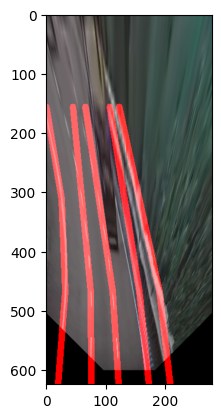

In [6]:
# Parameters
rho = 4             # Distance resolution of the grid in Hough Space
theta = np.pi/180   # Angular resolution of the grid in Hough Space
threshold = 50      # Minimum number of intersection in a grid for candidate line
min_line_len = 25
max_line_gap = 100

cv_image = cv2.imread('images/input10.png')
transformed_image = birdseye_transform(cv_image)[:, 500:1280-500]
canny_edges = preprocess_image(transformed_image)

plt.imshow(np.asarray(transformed_image, dtype=int))
plt.imshow(np.asarray(canny_edges, dtype=int), cmap='gray')

hough_lines = multi_segment_hough(canny_edges[:], rho, theta, threshold, min_line_len, max_line_gap, segment_count=4, lane_width=15)
hough_lines_img = draw_multi_segment_hough(canny_edges, hough_lines, segment_count=4)
result = weighted_img(hough_lines_img, transformed_image[:], α=0.8, β=1., λ=0.)

plt.imshow(result)

## Video + Kalman Tracking

In [2]:
video_name = 'video01'
input_file_name = f"video/{video_name}.mp4"
output_file_name = f"output/{video_name}_lane_hough.mp4"

import json
from sort.lane_tracking import SortLane

sort_lane = SortLane(iou_threshold=500)

cap = cv2.VideoCapture(input_file_name)

fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
fps = int(cap.get(cv2.CAP_PROP_FPS))
width, height = 1280-(500*2), 625
no_of_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
out = cv2.VideoWriter()
out.open(output_file_name, fourcc, fps, (width, height), True)

# Parameters
rho = 4
theta = np.pi/180
threshold = 50
min_line_len = 25
max_line_gap = 100
# Lanes result
lanes = []
try:
    for f in range(no_of_frames):
        ret, frame = cap.read()
        if not ret:
            break

        im = frame
        transformed_image = birdseye_transform(im)[:, 500:1280-500]
        canny_edges = preprocess_image(transformed_image)

        hough_lines = multi_segment_hough(canny_edges, rho, theta, threshold, min_line_len, max_line_gap, segment_count=4, lane_width=10)
        if len(hough_lines) > 0:
            hough_lines, X = sort_lane.update(np.array(hough_lines))
        else:
            hough_lines, X = sort_lane.update(np.empty((0, 4)))
        
        hough_lines_img = draw_multi_segment_hough(canny_edges, hough_lines, segment_count=4)
        im = weighted_img(hough_lines_img, transformed_image[:], α=0.8, β=1., λ=0.)

        # write the frame
        lanes.append(hough_lines.tolist())
        out.write(im)
except Exception as error:
    # Release resources
    import traceback
    print(traceback.format_exc())
finally:
    out.release()
    cap.release()

# Add to frames detections
with open(f'output/{video_name}_lanes.json', 'w', encoding='utf-8') as f:
    json.dump({ "lanes": lanes }, f, ensure_ascii=False, indent=4)

## 3D Lane

In [12]:
import trimesh

lane_tmesh = trimesh.load('objs3/Lane.obj')
lane_tmesh.visual.vertex_colors = [255, 255, 0, 255]
lane_tmesh.show()

In [20]:
cv_image = cv2.imread('images/input6.png')
height = int(cv_image.shape[0]) # row y
width = int(cv_image.shape[1]) # col x

cameraInfo = Info({
    "focalLengthX": int(width / 100) * 100, # 1200.6831,         # focal length x
    "focalLengthY": int(height / 100) * 100, # 1200.6831,         # focal length y
    "opticalCenterX": int(width / 2), # 638.1608,        # optical center x
    "opticalCenterY": int(height / 2), # 738.8648,       # optical center y
    "cameraHeight": 1500, # 1879.8,  # camera height in `mm`
    "pitch": 2.5,           # rotation degree around x
    "yaw": 0,              # rotation degree around y
    "roll": 0              # rotation degree around z
})
ipmInfo = Info({
    "inputWidth": width,
    "inputHeight": height,
    "left": 50,
    "right": width-50,
    "top": 475,
    "bottom": height
})

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


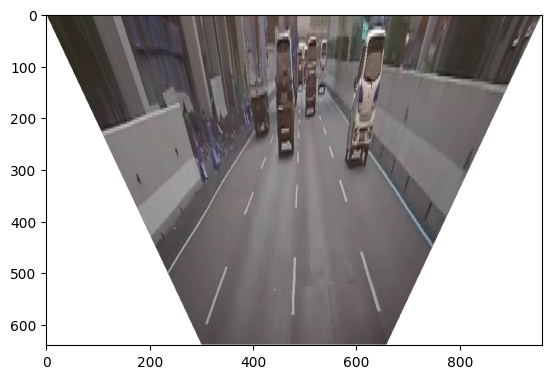

In [21]:
transformed_image = ipm_transform(cv_image, cameraInfo, ipmInfo)
plt.imshow(np.asarray(transformed_image, dtype=int))